In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# Chech torch and detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
import cv2
import matplotlib.pyplot as plt

# Receive a list of bbox, class, and score and an image, draw the bbox and the info
def visualize_detections(img, bboxes, class_ids, scores, class_names=None):

    for i, box in enumerate(bboxes):
        # Convert box coordinates to integers
        x1, y1, x2, y2 = map(int, box)

        # Draw the bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Prepare label with class name/ID and score
        label = f"{class_ids[i]}" if class_names is None else f"{class_names[class_ids[i]]}"
        label += f": {scores[i]:.2f}"

        # Calculate text size for background box
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Draw background rectangle for label text
        cv2.rectangle(img, (x1, y1 - h - 4), (x1 + w, y1), (0, 255, 0), -1)

        # Put the text on top of the bounding box
        cv2.putText(img, label, (x1, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Convert the image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image with detections using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    return img


#### Daytime

In [ ]:
# Config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.WEIGHTS = '/kaggle/input/fasterrcnn_daytime/output/model_final.pth'

# Create predictor
predictor = DefaultPredictor(cfg)

Test


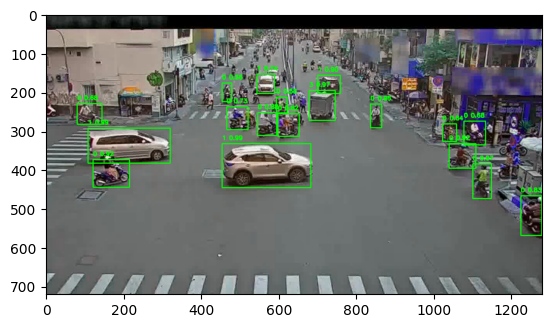

In [16]:
import matplotlib.pyplot as plt
image_folder = '/kaggle/input/bkai-public-test/public test'
image_name = 'cam_10_00772.jpg'
image_path = os.path.join(image_folder, image_name)
im = cv2.imread(image_path)
outputs = predictor(im)
bboxes = outputs['instances'].pred_boxes.tensor.tolist()
labels = outputs['instances'].pred_classes.tolist()
scores = outputs['instances'].scores.tolist()

for label, bbox, score in zip(labels, bboxes, scores):
    class_id = label
    x_min = int(float(bbox[0]))
    y_min = int(float(bbox[1]))
    x_max = int(float(bbox[2]))
    y_max = int(float(bbox[3]))
    confidence = float(score)
    # show the class id and confidence too
    cv2.rectangle(im, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(im, f'{class_id} {confidence:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(im)

In [2]:
def coco2yolo(bbox, im_h, im_w):
    x_min, y_min, x_max, y_max = bbox
    w = (x_max - x_min)/im_w
    h = (y_max - y_min)/im_h
    x_min /= im_w
    y_min /= im_h
    x = x_min + w/2
    y = y_min + h/2
    return (x, y, w, h)

In [ ]:
# Path to the directory containing test images
test_image_dir = '/kaggle/input/bkai-public-test/public test'
output_file_path = '/kaggle/working/fasterrcnn_daytime_result.txt'

# Open the output file in write mode
with open(output_file_path, 'w') as file:
    # Process each image
    for image_name in os.listdir(test_image_dir):
        if image_name.endswith('.json'):
            continue
        # Read the image
        image_path = os.path.join(test_image_dir, image_name)
        im = cv2.imread(image_path)
        outputs = predictor(im)
        bboxes = outputs['instances'].pred_boxes.tensor.tolist()
        labels = outputs['instances'].pred_classes.tolist()
        scores = outputs['instances'].scores.tolist()

        for label, bbox, score in zip(labels, bboxes, scores):
            xmin, ymin, xmax, ymax = bbox
            # Write to the file in the required format
            file.write(f"{image_name} {label} {xmin} {ymin} {xmax} {ymax} {score}\n")

print("Submission file created successfully!")

Submission file created successfully!


In [ ]:
import os
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'fasterrcnn_daytime_result.txt')

#### Nighttime

In [ ]:
# Config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.WEIGHTS = '/kaggle/input/fasterrcnn_nighttime/output/model_final.pth'

# Create predictor
predictor = DefaultPredictor(cfg)

In [ ]:
# Path to the directory containing test images
test_image_dir = '/kaggle/input/bkai-public-test/public test'
output_file_path = '/kaggle/working/fasterrcnn_nighttime_result.txt'

# Open the output file in write mode
with open(output_file_path, 'w') as file:
    # Process each image
    for image_name in os.listdir(test_image_dir):
        if image_name.endswith('.json'):
            continue
        # Read the image
        image_path = os.path.join(test_image_dir, image_name)
        im = cv2.imread(image_path)
        outputs = predictor(im)
        bboxes = outputs['instances'].pred_boxes.tensor.tolist()
        labels = outputs['instances'].pred_classes.tolist()
        scores = outputs['instances'].scores.tolist()

        for label, bbox, score in zip(labels, bboxes, scores):
            xmin, ymin, xmax, ymax = bbox
            # Write to the file in the required format
            file.write(f"{image_name} {label} {xmin} {ymin} {xmax} {ymax} {score}\n")

print("Submission file created successfully!")

In [ ]:
import os
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'fasterrcnn_daytime_result.txt')